In [1]:
library(tidyverse)
library(broom)
library(patchwork)
options(repr.plot.width=12, repr.plot.heigh=12)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Question 1

In [2]:
df <- read.csv('../data/mortality_by_latitude.csv')

In [3]:
head(df)

,latitude,mortality_index,temperature
,<int>,<int>,<dbl>
1,50,1025,51.3
2,51,1045,49.9
3,52,1004,50.0
4,53,959,49.2
5,54,870,48.5
6,55,950,47.8


In [4]:
lm.poly <- lm(mortality_index ~ temperature + I(temperature^2) +I(temperature^3), data=df)
df_augmented <- augment(lm.poly)

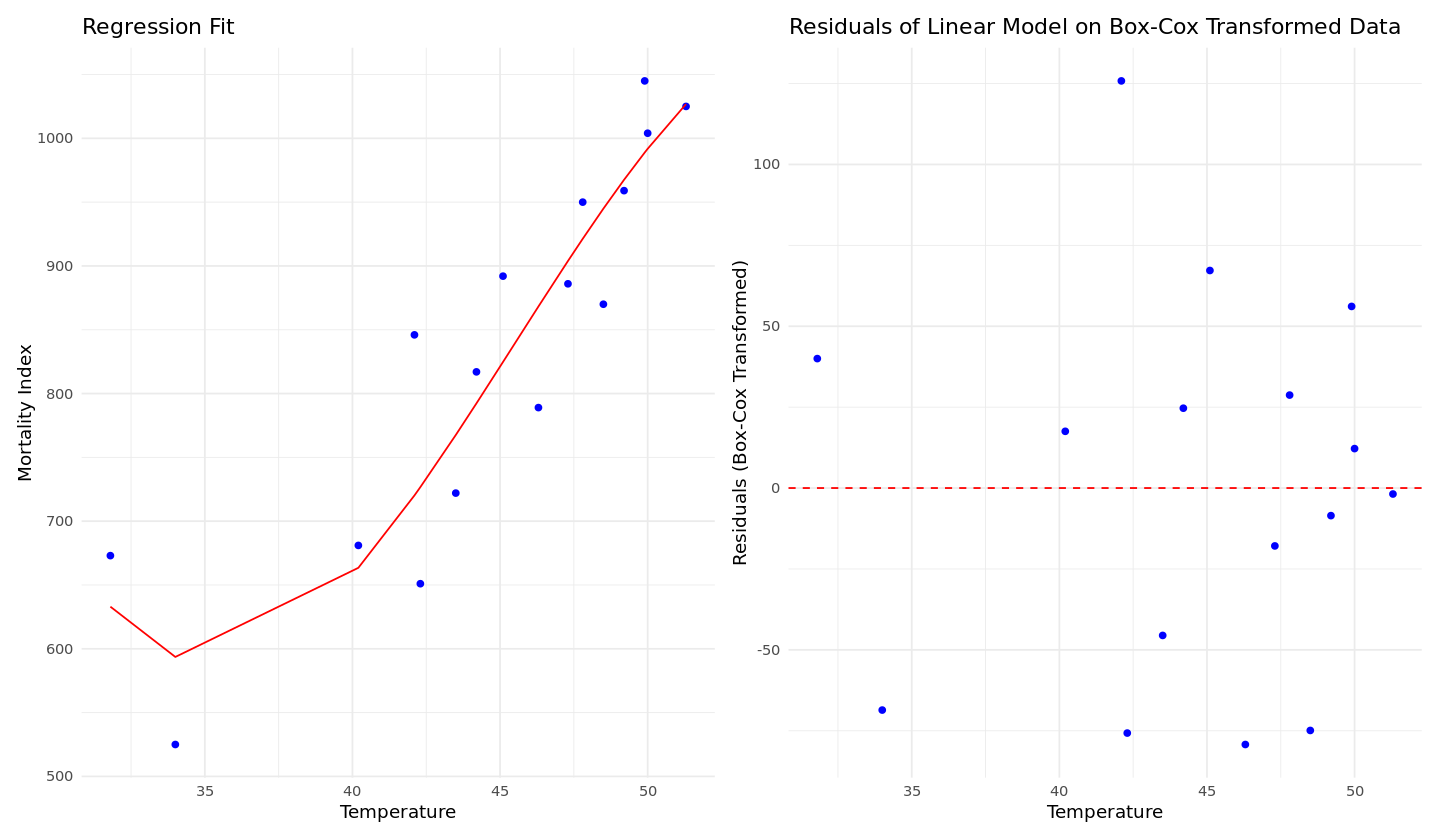

In [5]:
p1 <- ggplot(df_augmented, aes(x = temperature, y = mortality_index)) +
    geom_point(color = "blue") + 
    geom_line(aes(y = .fitted), color = "red") +  
    labs(title = "Regression Fit",
         x = "Temperature",
         y = "Mortality Index") +
    theme_minimal()


p2 <- ggplot(df_augmented, aes(x = temperature, y = .resid)) + 
    geom_point(color = "blue") +  
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") + 
    theme_minimal() +
    labs(title = "Residuals of Linear Model on Box-Cox Transformed Data",
         x = "Temperature",
         y = "Residuals (Box-Cox Transformed)")

p1 + p2 + plot_layout(widths = c(1, 1))

This graph is hollow up, we will now perform some transformations to straighten it out through the use of Box-Cox Transformations

In [6]:
box_cox <- function(y, tau) {
    if (any(y <= 0)) {
        stop("Box-Cox transformation requires y to be strictly positive.")
    }
    
    if (tau == 0) {
        return(log(y))  # Log transformation when tau = 0
    } else {
        return((y^tau - 1) / tau)
    }
}


`geom_smooth()` using formula = 'y ~ x'


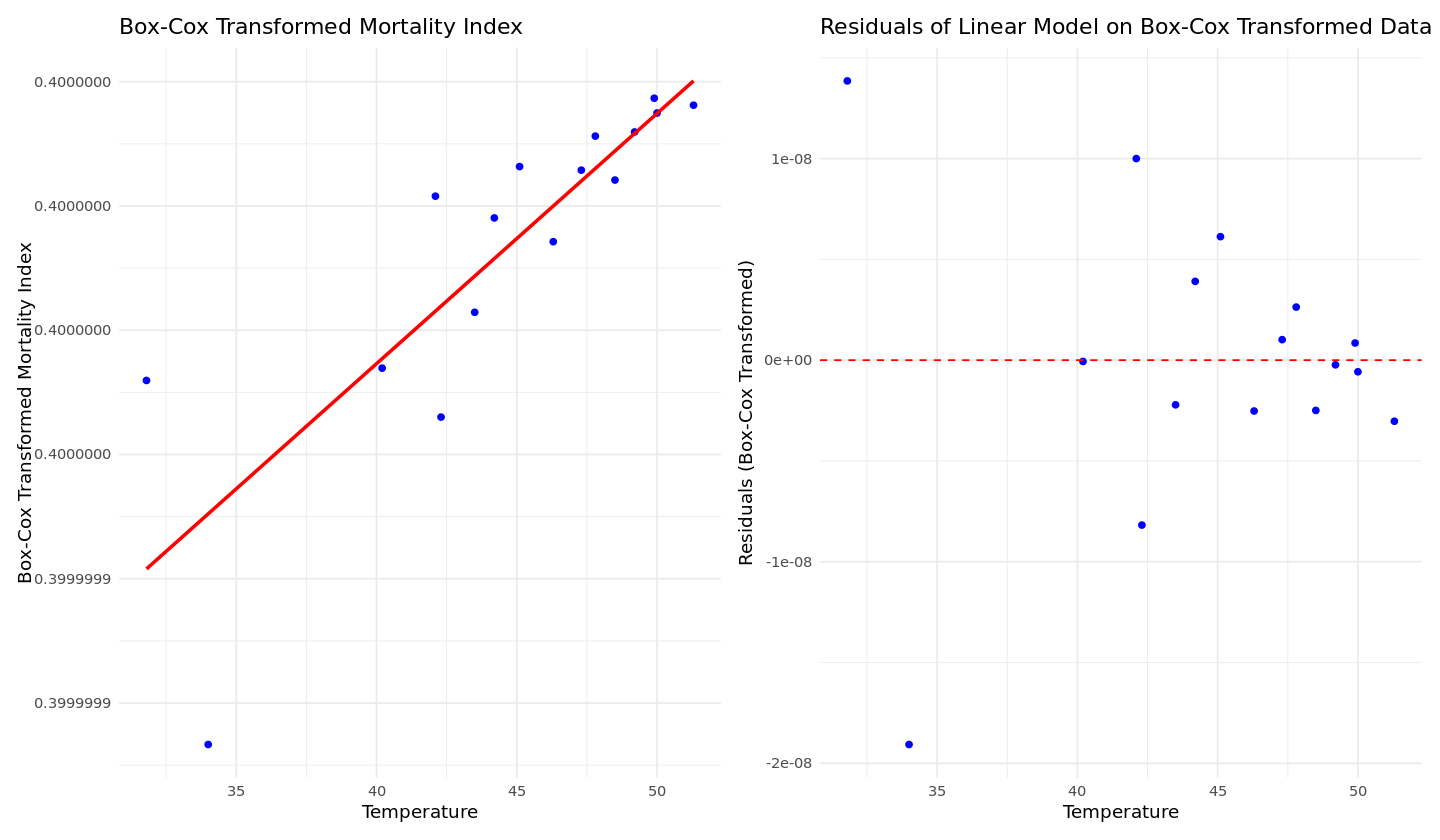

In [7]:

df_boxcox <- df  
df_boxcox$boxcox_mortality <- box_cox(df_boxcox$mortality_index, -2.5)
lm_boxcox <- lm(boxcox_mortality ~ temperature + I(temperature^2), data = df_boxcox)
df_boxcox_augmented <- augment(lm_boxcox)


p1 <- ggplot(df_boxcox_augmented, aes(x = temperature, y = boxcox_mortality)) +
    geom_point(color = "blue") +  
    stat_smooth(method = 'lm', se = FALSE, color = "red") +  
    theme_minimal() +
    labs(title = "Box-Cox Transformed Mortality Index",
         x = "Temperature",
         y = "Box-Cox Transformed Mortality Index")


p2 <- ggplot(df_boxcox_augmented, aes(x = temperature, y = .resid)) + 
    geom_point(color = "blue") +  
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") + 
    theme_minimal() +
    labs(title = "Residuals of Linear Model on Box-Cox Transformed Data",
         x = "Temperature",
         y = "Residuals (Box-Cox Transformed)")

p1 + p2 + plot_layout(widths = c(1, 1))


## Question 2

In [8]:

diamonds = ggplot2::diamonds |> dplyr::mutate(log_price = log10(price))


In [9]:
str(diamonds)

tibble [53,940 × 11] (S3: tbl_df/tbl/data.frame)
 $ carat    : num [1:53940] 0.23 0.21 0.23 0.29 0.31 0.24 0.24 0.26 0.22 0.23 ...
 $ cut      : Ord.factor w/ 5 levels "Fair"<"Good"<..: 5 4 2 4 2 3 3 3 1 3 ...
 $ color    : Ord.factor w/ 7 levels "D"<"E"<"F"<"G"<..: 2 2 2 6 7 7 6 5 2 5 ...
 $ clarity  : Ord.factor w/ 8 levels "I1"<"SI2"<"SI1"<..: 2 3 5 4 2 6 7 3 4 5 ...
 $ depth    : num [1:53940] 61.5 59.8 56.9 62.4 63.3 62.8 62.3 61.9 65.1 59.4 ...
 $ table    : num [1:53940] 55 61 65 58 58 57 57 55 61 61 ...
 $ price    : int [1:53940] 326 326 327 334 335 336 336 337 337 338 ...
 $ x        : num [1:53940] 3.95 3.89 4.05 4.2 4.34 3.94 3.95 4.07 3.87 4 ...
 $ y        : num [1:53940] 3.98 3.84 4.07 4.23 4.35 3.96 3.98 4.11 3.78 4.05 ...
 $ z        : num [1:53940] 2.43 2.31 2.31 2.63 2.75 2.48 2.47 2.53 2.49 2.39 ...
 $ log_price: num [1:53940] 2.51 2.51 2.51 2.52 2.53 ...


In [10]:
diamonds_subset <- subset(diamonds, clarity == "VS1")

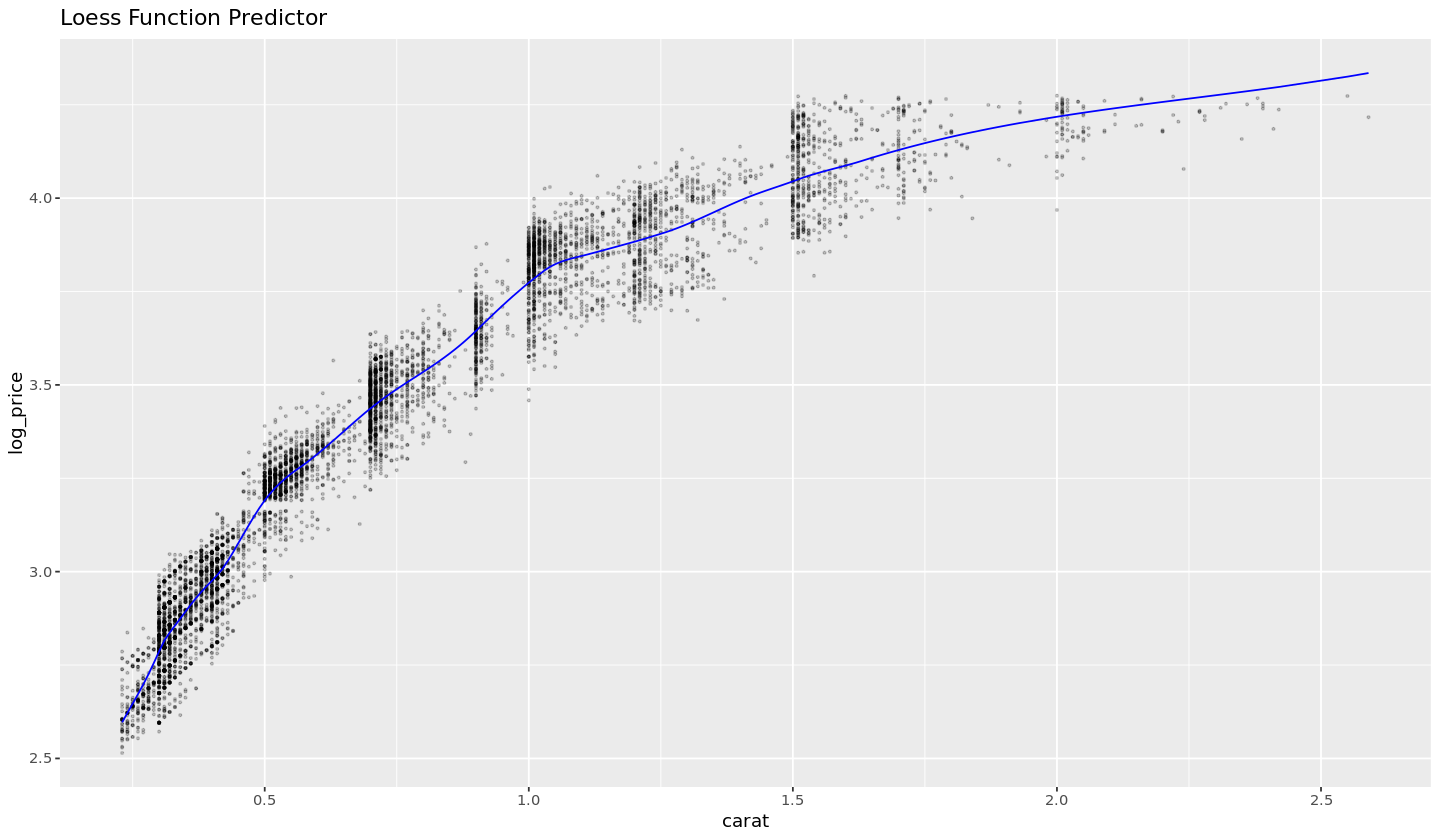

In [22]:

# Fit loess model on subset
l.out <- loess(log_price ~ carat, data = diamonds_subset, span = .2, degree = 1)

ggplot(augment(l.out )) +
    geom_point(aes(x = carat, y = log_price), size = .5, alpha = .2) +
    geom_line(aes(x = carat, y = .fitted), color = "blue") +
    labs(title = "Loess Function Predictor")

### Question 3

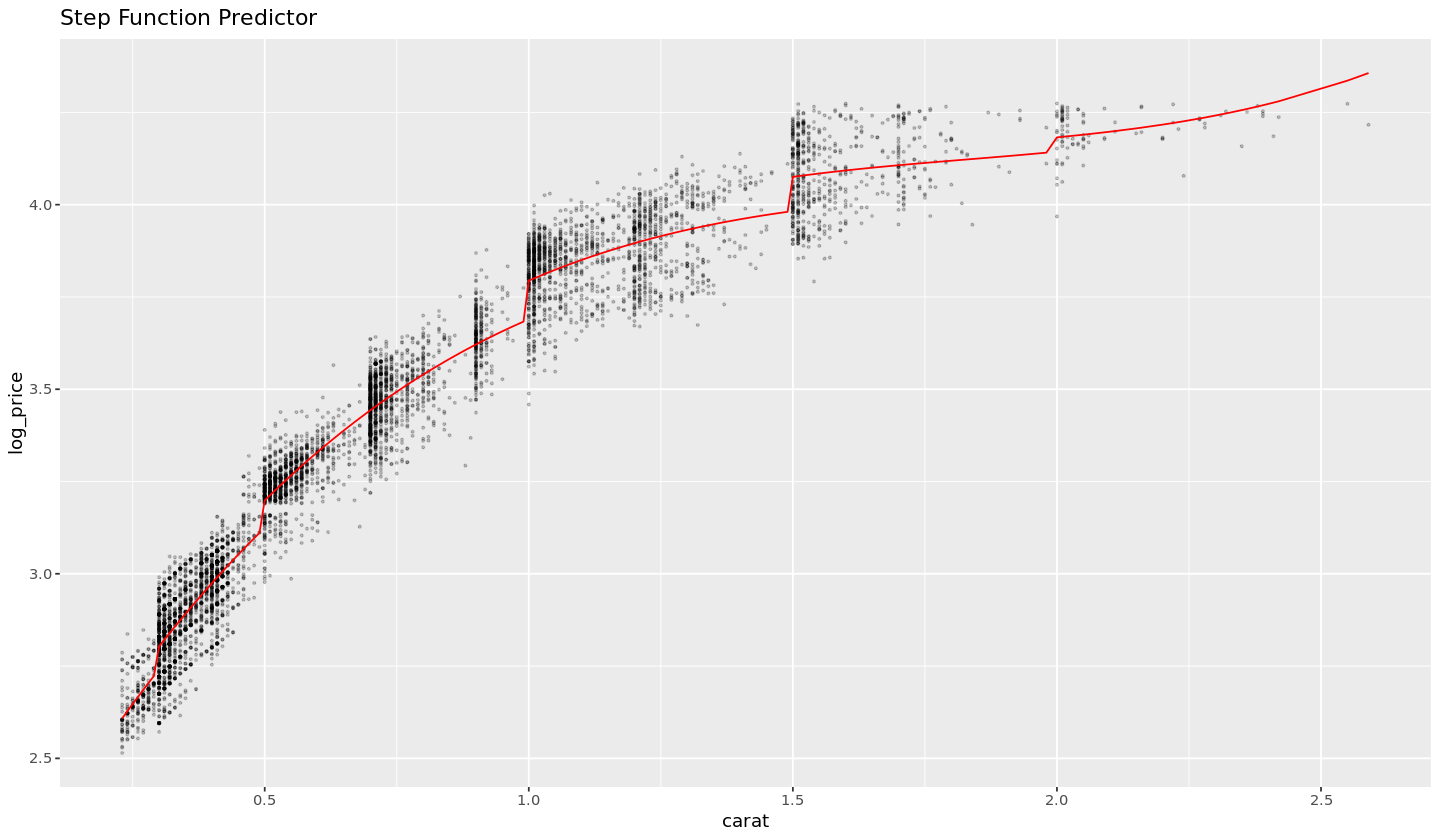

In [23]:
step = function(x, step_position) {
    return(ifelse(x >= step_position, 1, 0))
}
lm.steps = lm(
    log_price ~
        carat + I(carat^2) + I(carat^3) +
        step(carat, .3) + step(carat, .5) + step(carat, 1) +
        step(carat, 1.5) + step(carat, 2),
    data = diamonds_subset)
    
ggplot(augment(lm.steps)) +
    geom_point(aes(x = carat, y = log_price), size = .5, alpha = .2) +
    geom_line(aes(x = carat, y = .fitted), color = "red") +
    labs(title = "Step Function Predictor")

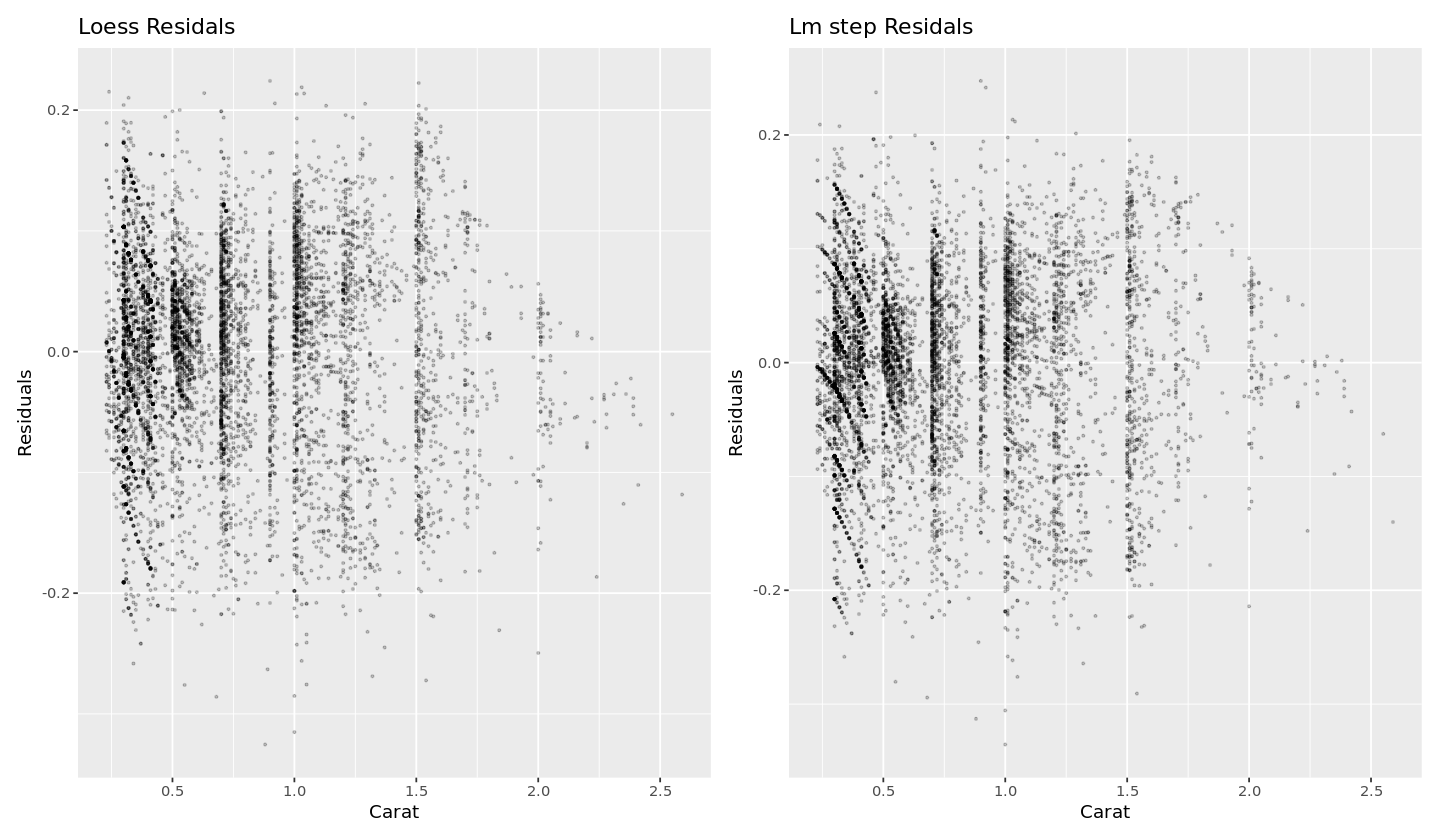

In [24]:
p1 <- ggplot(augment(l.out)) +
    geom_point(aes(x = carat, y = .resid), size = .5, alpha = .2) +
    labs(title = "Loess Residals", x= "Carat", y="Residuals")

p2 <- ggplot(augment(lm.steps)) +
    geom_point(aes(x = carat, y = .resid), size = .5, alpha = .2) +
    labs(title = "Lm step Residals", x= "Carat", y="Residuals")


p1 + p2 + plot_layout(widths = c(1, 1))

